In [62]:
import pandas as pd
import numpy as np
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from surprise import SVD
from surprise import SVDpp
from surprise import BaselineOnly
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
# from surprise.model_selection import train_test_split


### Load Data

In [43]:
def loadData(filenam e):
    print("Loading Data.....")
    data=pd.read_csv(filename) 
    data=data[["adGroup","placement","target"]]
    adGroupList=pd.unique(data["adGroup"])
    # A reader is still needed but only the rating_scale param is requiered.
    reader = Reader(rating_scale=(0, data['target'].max()))
    x_train, x_test, y_train, y_test = train_test_split(data, np.ones(data.shape[0]), test_size=0.2, random_state=33)
    
    # The columns must correspond to user id, item id and ratings (in that order).
    x_train = Dataset.load_from_df(x_train[["adGroup","placement","target"]], reader)
    x_train = x_train.build_full_trainset()
    x_test=x_test.rename(columns={"target":"groudTruth"})
    print("Finished Loading!")
    print(type(x_test))
    return x_train,x_test


### Define the estimation matrix

In [20]:
def PrecisionRecall(x_test,pred,N):
    hit = 0
    n_recall = 1
    n_precision = 1

    adGroupList=pd.unique(x_test["adGroup"])
    print("---------N:",N)
    print("Evaluating the model......")
    for adGroup in adGroupList:
        topN=pred.loc[pred["adGroup"]==adGroup].sort_values("est",ascending=False)[:N]
        groundTruth=x_test.loc[x_test["adGroup"]==adGroup]
        groundTruth=groundTruth[groundTruth["groudTruth"]>0]

        intersection = pd.merge(topN,
                 groundTruth,
                 how='inner', on=['adGroup','placement']
                 )
        hit += intersection.shape[0]
        n_recall += groundTruth.shape[0]
        n_precision += N

       
    return [hit / (1.0 * n_recall), hit / (1.0 * n_precision)]


In [21]:
def build_anti_testset(X_train, fill=None):
        fill = X_train["target"].mean() if fill is None else float(fill)
        print(X_train.head())
        adGroupList=pd.unique(X_train["adGroup"])
        placementList=pd.unique(X_train["placement"])
        anti_testset = []
        for adGroup in adGroupList:
            already=x_test.loc[x_test["adGroup"]==adGroup]["placement"]
            anti_testset += [(self.to_raw_uid(u), self.to_raw_iid(i), fill) for
                             i in placementList if
                             i not in already]
            
        return anti_testset

### Using Baseline Predictor 
RMSE is about 0.345

In [71]:
def trainModel(Model,filename,topN_low,topN_high):
    trainset,x_test=loadData(filename)
    
    # The ratings are all the ratings that are not in the trainset
    antiTrain=trainset.build_anti_testset(fill=None)
#     print(x_test.head())
    # Build an algorithm, and train it.
    if Model=="Baseline":
        bsl_options = {'method': 'als',
                   'n_epochs': 1000,
                   'reg_u': 12,
                   'reg_i': 5
                   }
        algo = BaselineOnly(bsl_options=bsl_options)
    elif Model=="SVD":
        algo = SVD(n_epochs=100)
    elif Model=="SVDpp":
        algo = SVDpp(n_epochs=100)
        
    algo.fit(trainset)
    print("Finished Training")
#     mse=mean_squared_error(algo.test(x_test), x_test)
    reader = Reader(rating_scale=(0, x_test['groudTruth'].max()))

    test=Dataset.load_from_df(x_test[["adGroup","placement","groudTruth"]], reader)
    test=test.build_full_trainset().build_testset()
   
    mse=accuracy.mse(algo.test(test), verbose=True)
#     print(mse)
    #Predict anti-data data
    pred=algo.test(antiTrain)
    pred=pd.DataFrame(pred).rename(columns={"uid": "adGroup", "iid": "placement"})
    precisions=[]
    recalls=[]
    topNs=[]
    for topN in range(topN_low,topN_high+1,50):
        recall,precision=PrecisionRecall(x_test,pred,topN)
        precisions.append(precision)
        recalls.append(recall)
        topNs.append(topN)
        print("Recall: {}, Precision: {} ".format(round(recall,3),round(precision,3)))
    plt.plot(topNs, recalls, label='Recalls')
    plt.title('Model TopN Recall')
    plt.ylabel('Recall')
    plt.xlabel('TopN')
    plt.legend(['Recalls', 'Precision'], loc='upper left')
    plt.show()
    
    
    plt.plot(topNs, precisions, label='Recalls')
    plt.title('Model TopN Precision')
    plt.ylabel('Precision')
    plt.xlabel('TopN')
    plt.legend(['Recalls', 'Precision'], loc='upper left')
    plt.show()

Loading Data.....
Finished Loading!
<class 'pandas.core.frame.DataFrame'>
Estimating biases using als...
Finished Training
MSE: 0.1217
---------N: 100
Evaluating the model......
Recall: 0.16, Precision: 0.016 
---------N: 150
Evaluating the model......
Recall: 0.211, Precision: 0.014 
---------N: 200
Evaluating the model......
Recall: 0.252, Precision: 0.013 
---------N: 250
Evaluating the model......
Recall: 0.298, Precision: 0.012 
---------N: 300
Evaluating the model......
Recall: 0.346, Precision: 0.012 
---------N: 350
Evaluating the model......
Recall: 0.384, Precision: 0.011 
---------N: 400
Evaluating the model......
Recall: 0.427, Precision: 0.011 
---------N: 450
Evaluating the model......
Recall: 0.483, Precision: 0.011 
---------N: 500
Evaluating the model......
Recall: 0.545, Precision: 0.011 


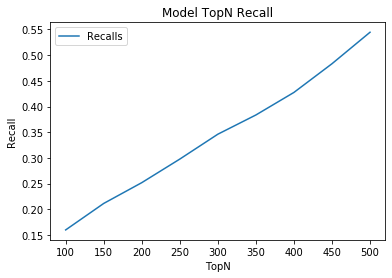

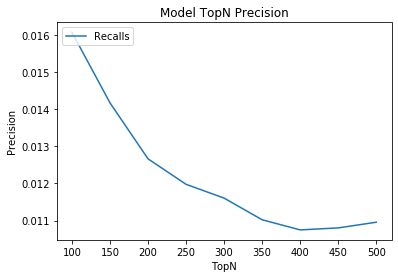

In [72]:
trainModel("Baseline","result.csv",100,500)

Loading Data.....
Finished Loading!
<class 'pandas.core.frame.DataFrame'>
Finished Training
MSE: 0.1237
---------N: 100
Evaluating the model......
Recall: 0.144, Precision: 0.014 
---------N: 150
Evaluating the model......
Recall: 0.196, Precision: 0.013 
---------N: 200
Evaluating the model......
Recall: 0.242, Precision: 0.012 
---------N: 250
Evaluating the model......
Recall: 0.288, Precision: 0.012 
---------N: 300
Evaluating the model......
Recall: 0.333, Precision: 0.011 
---------N: 350
Evaluating the model......
Recall: 0.387, Precision: 0.011 
---------N: 400
Evaluating the model......
Recall: 0.445, Precision: 0.011 
---------N: 450
Evaluating the model......
Recall: 0.507, Precision: 0.011 
---------N: 500
Evaluating the model......
Recall: 0.57, Precision: 0.011 


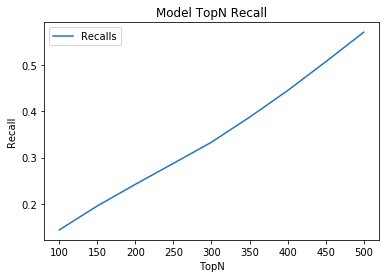

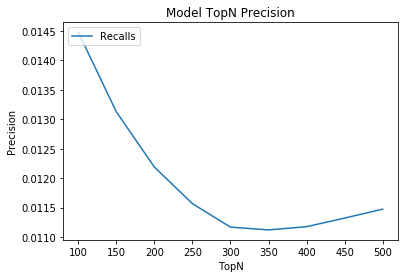

In [73]:
trainModel("SVD","result.csv",100,500)

### SVDpp 非常慢！

Loading Data.....
Finished Loading!
<class 'pandas.core.frame.DataFrame'>
Finished Training
MSE: 0.1235
---------N: 100
Evaluating the model......
Recall: 0.142, Precision: 0.014 
---------N: 150
Evaluating the model......
Recall: 0.188, Precision: 0.013 
---------N: 200
Evaluating the model......
Recall: 0.235, Precision: 0.012 
---------N: 250
Evaluating the model......
Recall: 0.282, Precision: 0.011 
---------N: 300
Evaluating the model......
Recall: 0.33, Precision: 0.011 
---------N: 350
Evaluating the model......
Recall: 0.379, Precision: 0.011 
---------N: 400
Evaluating the model......
Recall: 0.431, Precision: 0.011 
---------N: 450
Evaluating the model......
Recall: 0.492, Precision: 0.011 
---------N: 500
Evaluating the model......
Recall: 0.554, Precision: 0.011 


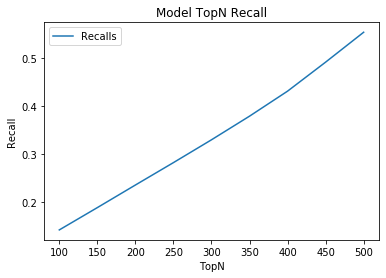

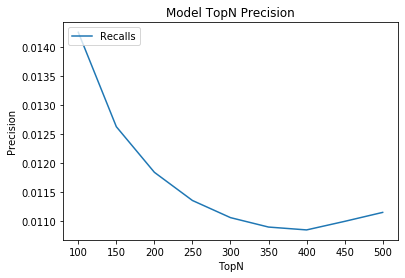

In [74]:
trainModel("SVDpp","result.csv",100,500)